# Analyzing Presidential inaugural speeches

In [192]:
import nltk
#nltk.download('inaugural')
from nltk.corpus import inaugural
import pandas as pd
import requests
from bs4 import BeautifulSoup  
from string import punctuation
stop_words = nltk.corpus.stopwords.words('english')
wordnet = nltk.stem.WordNetLemmatizer()
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Creating a table

In [141]:
#
year = []
name = []
text = []
for fileid in inaugural.fileids():
    year.append(fileid[:4])
    name.append(fileid.split('-')[1].split('.')[0])
    text.append(inaugural.raw(fileid))
name[53]='W.Bush'              #to differentiate G.Bush from G.W.Bush
name[54]='W.Bush'
name[29]='T.Roosevelt'         #to differentiate T.Roosevelt from F.D.Roosevelt
name[2]='J.Adams'              # to differentiate J.Adams from J.Q.Adams
name[13]='W.H.Harrison'        # to differentiate W.H.Harrison from B.Harrison

df_all = pd.DataFrame(list(zip(year,name,text)),columns = ['Year','Name','Text'])
df = df_all.drop_duplicates(subset=['Name'],keep='first')
  #
df = df.reset_index(drop=True)

# for party info I am using web scrapping
url = 'https://www.thoughtco.com/presidents-and-vice-presidents-chart-4051729'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

pname = []
pparty=[]
table = soup.find('tbody')
for row in table.find_all('tr'):
    cell = row.find_all('td')
    pname.append(cell[0].text)
    pparty.append(cell[2].text)
df_party = pd.DataFrame(list(zip(pname,pparty)),columns=('Name','Party'))
df_party = df_party.drop([9,12,16,20,23,37],axis=0)
df_party = df_party.reset_index(drop=True)


df.loc[:,'Party']=df_party['Party']


In [142]:
def preprocessing(string):
    speech = string.strip(punctuation).lower()
    speech = nltk.tokenize.word_tokenize(speech)
    words = [w for w in speech if w not in stop_words]
    lemm = [wordnet.lemmatize(w) for w in words]
    lemm =[w for w in lemm if len(w) > 2]
    lemm = [w for w in lemm if w not in ['mr.']]
    return lemm
    

In [167]:
t=[]
for x in range (0,39):
    t.append(len(preprocessing(df.at[x,'Text'])))
t
df.loc[:,'Vocab']=t
df.head(5)


,Year,Name,Text,Party,Vocab
0,1789,Washington,Fellow-Citizens of the Senate and of the House...,No Party Designation,644
1,1797,J.Adams,"When it was first perceived, in early times, t...",Federalist,1059
2,1801,Jefferson,Friends and Fellow Citizens:\n\nCalled upon to...,Democratic-Republican,804
3,1809,Madison,Unwilling to depart from examples of the most ...,Democratic-Republican,518
4,1817,Monroe,I should be destitute of feeling if I was not ...,Democratic-Republican,1536


### 1. Which president has the most vocabulary as evident from their inaugural speeches, and which presidents has the least vocabulary? On average, do Democratic or Republican presidents have higher vocabulary?

In [144]:
print('President with most vocabulary is ')
df[df['Vocab']==df['Vocab'].max()]



President with most vocabulary is 


,Year,Name,Text,Party,Vocab
8,1841,W.H.Harrison,Called from a retirement which I had supposed ...,Whig,3777


In [145]:
print('President with least vocabulary is ')
df[df['Vocab']==df['Vocab'].min()]

President with least vocabulary is 


,Year,Name,Text,Party,Vocab
20,1905,T.Roosevelt,"My fellow citizens, no people on earth have mo...",Republican,430


In [146]:
df.groupby('Party').mean()

,Vocab
Party,
Democratic,1070.571429
Democratic-Republican,1052.250000
Federalist,1059.000000
No Party Designation,644.000000
Republican,1323.187500
Union,1612.000000
Whig,2146.000000


Among Democrats and Republicans, on an average Republicans have higher vocabulary.

### 2. Creating a barplot of presidential vocabulary from the earliest president (Washington) to the latest (Trump) in this sample of 44 presidents (excluding stop words).

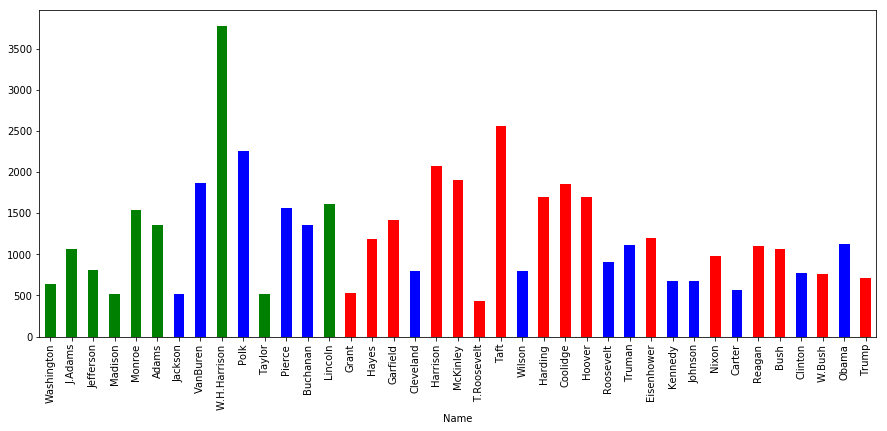

In [169]:
colors = []
for x in range (0,39):
    k = df.at[x,'Party']
    if(k=='Democratic'):
        colors.append('b')
    elif(k=='Republican'):
        colors.append('r')
    else:
        colors.append('g')
    
df.plot.bar(x='Name',y='Vocab',rot=90,figsize=(15,6),color = colors,legend = None)

### 3. 5 words (exclusive of stop words) used most frequently by each president? Do Democratic presidents use a different set of words than Republican presidents? 

In [156]:
demo = []
rep = []
for x in range(0,39):
    fd = nltk.FreqDist(preprocessing(df.at[x,'Text']))
    print('{} \t {}'.format(df.at[x,'Name'],(list(fd.keys())[0:5])))
    if(df.at[x,'Party']=='Democratic'):
        demo.extend((list(fd.keys())[0:5]))
    elif(df.at[x,'Party']=='Republican'):
        rep.extend((list(fd.keys())[0:5]))

Washington 	 ['fellow-citizens', 'senate', 'house', 'representative', 'among']
J.Adams 	 ['first', 'perceived', 'early', 'time', 'middle']
Jefferson 	 ['friend', 'fellow', 'citizen', 'called', 'upon']
Madison 	 ['unwilling', 'depart', 'example', 'revered', 'authority']
Monroe 	 ['destitute', 'feeling', 'deeply', 'affected', 'strong']
Adams 	 ['compliance', 'usage', 'coeval', 'existence', 'federal']
Jackson 	 ['fellow', 'citizen', 'undertake', 'arduous', 'duty']
VanBuren 	 ['fellow', 'citizen', 'practice', 'predecessor', 'imposes']
W.H.Harrison 	 ['called', 'retirement', 'supposed', 'continue', 'residue']
Polk 	 ['fellow', 'citizen', 'without', 'solicitation', 'part']
Taylor 	 ['elected', 'american', 'people', 'highest', 'office']
Pierce 	 ['countryman', 'relief', 'feel', 'heart', 'know']
Buchanan 	 ['fellow', 'citizen', 'appear', 'day', 'take']
Lincoln 	 ['fellow-citizens', 'united', 'state', 'compliance', 'custom']
Grant 	 ['citizen', 'united', 'state', 'suffrage', 'elected']
Hayes 	 

In [165]:
count=0
fd2 = nltk.FreqDist(demo)
fd3 = nltk.FreqDist(rep)
for x in list(fd2.keys()):
    for y in list(fd3.keys()):
        if(x==y):
            count += 1
sum = len(fd2)+len(fd3)
print('Of the words used by Democrats and Republicans {:.2f} % words are same'.format((count/sum)*100))

Of the words used by Democrats and Republicans 11.54 % words are same


### 4. Computing a sentiment (positive/negative) for each president.

In [191]:
sent=[]
for x in range (0,39):
    k=(analyzer.polarity_scores(df.at[x,'Text']))
    p=(k['pos'])/(k['neg'])
    sent.append(round(p,2))
df.loc[:,'Sentiment']=sent
df.head(5)


,Year,Name,Text,Party,Vocab,Sentiment
0,1789,Washington,Fellow-Citizens of the Senate and of the House...,No Party Designation,644,4.88
1,1797,J.Adams,"When it was first perceived, in early times, t...",Federalist,1059,5.27
2,1801,Jefferson,Friends and Fellow Citizens:\n\nCalled upon to...,Democratic-Republican,804,2.72
3,1809,Madison,Unwilling to depart from examples of the most ...,Democratic-Republican,518,3.37
4,1817,Monroe,I should be destitute of feeling if I was not ...,Democratic-Republican,1536,3.88


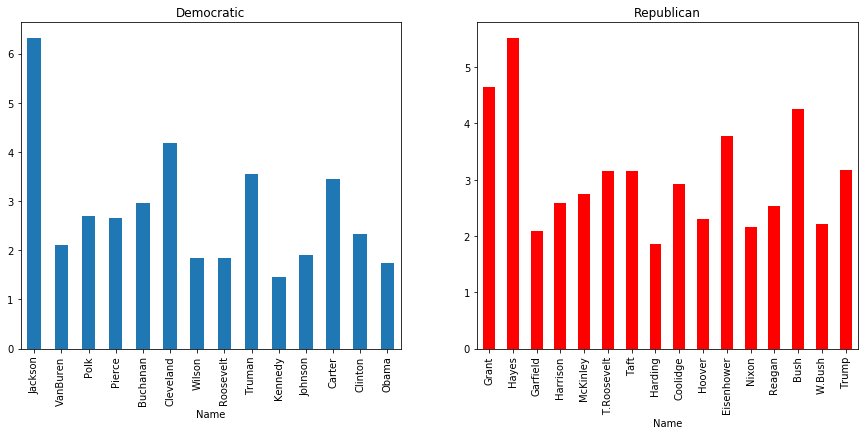

In [209]:
group = df.groupby('Party')
demo=group.get_group('Democratic')
repo=group.get_group('Republican')
fig, (ax, ax2) = plt.subplots(ncols=2,)
demo.plot.bar(x='Name',y='Sentiment',figsize=(15,6), legend=False,ax=ax)
ax.set_title('Democratic')
repo.plot.bar(x='Name',y='Sentiment',figsize=(15,6),color = 'r', legend=False,ax=ax2)
ax2.set_title('Republican')
plt.show()

Highest positive sentiment:

Democrats:
1.Jackson
2.Cleveland
3.Truman

Republicans:
1.Hayes
2.Grant
3.Bush

In [213]:
print('Democrats mean \n {} '.format(demo.mean()))
print('Republican mean \n {} '.format(repo.mean()))
print('Republicans have highest mean positive sentiment score.')

Democrats mean 
 Year         1.306560e+54
Vocab        1.070571e+03
Sentiment    2.792143e+00
dtype: float64 
Republican mean 
 Year         1.168242e+62
Vocab        1.323188e+03
Sentiment    3.067500e+00
dtype: float64 
Republicans have highest mean positive sentiment score.


In [216]:
dff =df.drop(columns='Text') 
dff.to_csv(r'Presidential_Speeches.csv',index = None,header=True)
